In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gzip
import dateutil
import scipy
import csv

In [25]:
DATA_DIR = Path("../data")

The following code code reads real PWV measurements for 2023 made using the Low Humidity And Temperature Profiling microwave radiometer at the Paranal Observatory, available trough the [LHATPRO Query Form](https://archive.eso.org/wdb/wdb/asm/lhatpro_paranal/form).

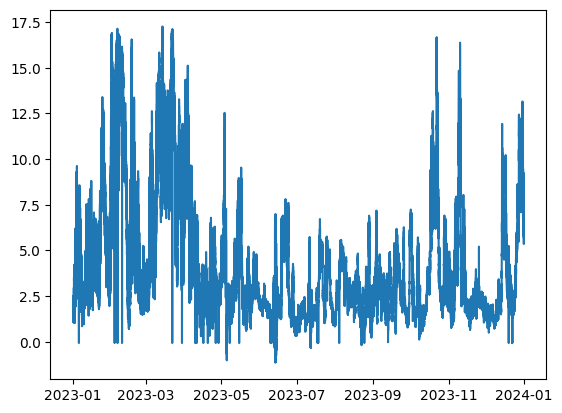

d:\Documents\AIExperiments\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2357: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


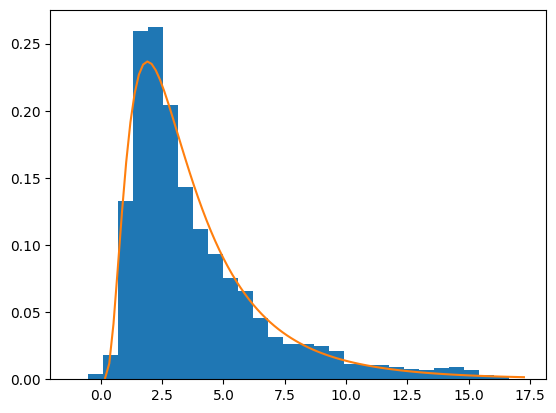

FitParams(s=0.6959808999861994, loc=0.0, scale=3.0862418980141153)


In [57]:
timestamps = []
pwv_values = []

with gzip.open(DATA_DIR / "wdb_query_eso.csv.gz", mode="rt", newline="") as fp:
	reader = csv.reader(fp)
	next(reader)
	next(reader)
	for row in reader:
		if len(row) == 3:
			p, t, pwv = row
			if pwv:
				t = dateutil.parser.parse(t)
				pwv = float(pwv)
				timestamps.append(t)
				pwv_values.append(pwv)

pwv_values = np.array(pwv_values)

plt.plot(timestamps, pwv_values)
plt.show()
plt.hist(pwv_values, bins=30, density=True)
#plt.show()

bounds = { "s": (0, 1), "loc": (0, 0), "scale": (0, 10) }
result = scipy.stats.fit(scipy.stats.lognorm, pwv_values, bounds=bounds)
params = result.params
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv_values.max(), step=pwv_values.max() / 100) + pwv_values.max() / 100
plt.plot(span, distribution.pdf(span))
plt.show()

print(params)

This stochastic process is such that $V_{k+1}=p \cdot V_k+R_{k+1}$, where $R_i$ variables are iid with distribution $\mathcal{N}(0,1)$ and $0 \le p<1$.

When $k$ is large, $\mathrm{Var}(V_k)$ converges to $\frac{1}{1-p^2}$, due to the properties of geometric series. If $V_0$ has this same variance too and is a normally-distributed random variable independent of all $R_i$ variables, then $\mathrm{Var}(V_k)$ is constant and the sampling can start at any point.

Any long segment of the generated sequence is expected to have the same mean and variance as that of any $V_k$. This is a consequence of the fact that any two elements which are sufficiently far away in the sequence are nearly independent.

Multiplying every element of the sequence by $\sqrt{1-p^2}$ results in a new sequence of variables $S_i$ with a variance and standard deviation of 1.

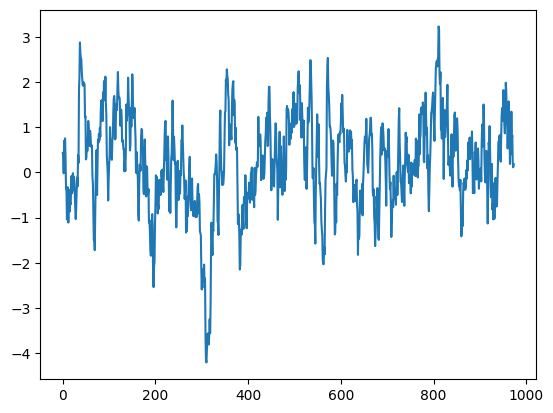

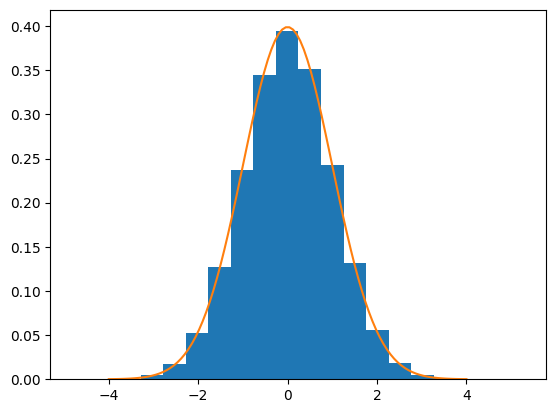

In [47]:
def random_process(size, p):
	random = np.random.normal(size=size)
	v = random[0] / np.sqrt(1 - p ** 2)
	sequence = [v]
	for r in random[1:]:
		v = v * p + r
		sequence.append(v)
	sequence = np.asarray(sequence)
	sequence *= np.sqrt(1 - p ** 2)
	return sequence

s = random_process(1000000, 0.9)

plt.plot(s[:974])
plt.show()

plt.hist(s, bins=20, density=True)
#plt.show()

x = np.linspace(-4, 4, 100)
plt.plot(x, scipy.stats.norm.pdf(x))
plt.show()

The expected difference between any two values of a sequence $S$ as decribed above is 0. However, its variance depends on their distance along the sequence.

$\mathrm{Var}(S_n - S_m)$ is 0 when $d=n-m=0$ (since they are really the same element) and then it grows monotonically with $d$. When $n \gg m$, $S_m$ and $S_n$ are nearly independent, so $S_n + (-S_m)$ is effectively the sum of two independent normally distributed random variables and its variance approaches 2, drawing a horizontal asymptote.

From the graph below it can be seen that the value of $p$ can be used to control the rate at which the standard deviation of the difference between two elements in the sequence grows with their distance: the lower $p$ is, the faster elements vary in the sequence.

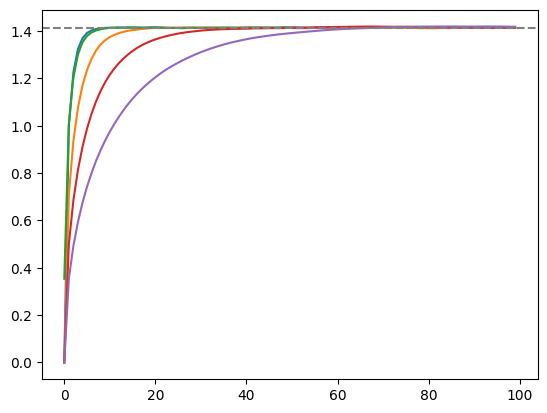

In [48]:
for exp in range(1, 5):
	sequence = random_process(1000000, 1 - 0.5 ** exp)
	stds = [0]
	for i in range(1, 100):
		diffs = sequence[i:] - sequence[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()
	if exp == 2:
		stds_means = np.mean(stds.reshape(-1, 2), axis=1)
		plt.plot(stds_means)
		#plt.show()

plt.axhline(y=np.sqrt(2), linestyle="--", color="gray")

plt.show()

The following code generates a random sequence of fake PVW values. The values across the sequence will have a lognormal distribution. The parameters of the distribution and the pace of variation across the sequence must be set to realistic values.

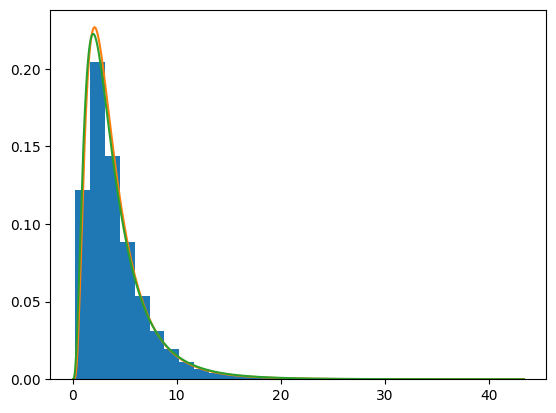

In [49]:
def random_pwv(size, dt=1, pace=1e4, sigma=0.69598, scale=3.0862):
	pace /= dt
	p = pace / (pace + 1)
	sequence = random_process(size, p)
	sequence *= sigma
	pwv = np.exp(sequence)
	pwv *= scale
	return pwv

pwv = random_pwv(10000000)

plt.hist(pwv, bins=30, density=True)
#plt.show()

distribution = scipy.stats.lognorm(0.667, scale=3.294)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
#plt.show()

params = scipy.stats.lognorm.fit(pwv)
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
plt.show()

The following code shows the effect of the `pace` parameter on how fast values vary throughout the generated sequence.

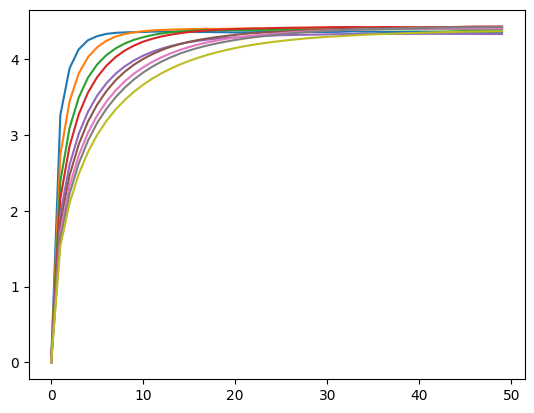

In [50]:
for pace in range(1, 10):
	pwv = random_pwv(1000000, pace=pace)
	stds = [0]
	for i in range(1, 50):
		diffs = pwv[i:] - pwv[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()

plt.show()

The following code exemplifies the generation of PWV sequences with a duration of 5 hours represented trough 59 samples.

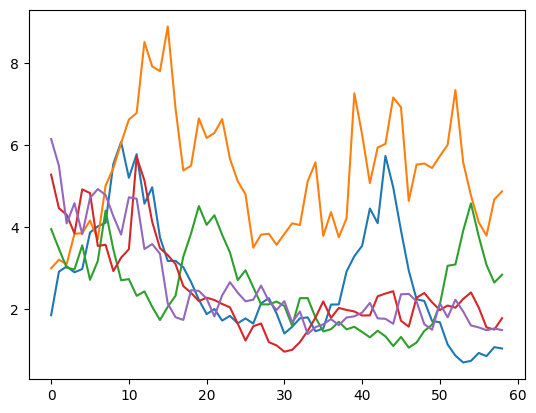

In [51]:
timespan = 5 * 60 * 60
size = 59

for i in range(5):
	pwv = random_pwv(size, dt=timespan / size)
	plt.plot(pwv)
	#plt.show()

plt.show()